In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Project questions:
* What are the 5 most popular trips that you would call "commuter trips"?
* What are your recommendations for offers (justify based on you findings)?

# Commuter Trips

First we have to define what we consider to be "commuter trips" and clean up the data accordingly. These are the assumptions I made for characteristics of commuter trips in order to separate them from casual trips:
- Day of week: Assuming a work structure of a typical 9-5 job, commute trips would be made on weekdays as opposed to weekends.
- Time of day: Commuters will be making their trips in the mornings to get to work and again in the afternoon when leaving work. For the thresholds, I used between 6-8am for morning bike trip start times and 5-7pm for afternoon bike trip start times.
- Duration: I limited commuter trips to trips lasting less than 1 hour. Considering there are alternate forms of transportation, it is unlikely that a commute by bike would be more than 1 hour long.

```sql
SELECT trip_id, start_station_name, end_station_name, subscriber_type,  
FROM `liquid-receiver-288223.bike_trip_data.dow_time_trips` 
WHERE duration_sec < 3600
  AND dow_weekday="Weekday"
  AND (start_hour_str="Morning" OR start_hour_str="Afternoon")
```

In [34]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT trip_id, start_station_name, end_station_name, start_hour_str, start_station_id, end_station_id, subscriber_type,  FROM `liquid-receiver-288223.bike_trip_data.dow_time_trips` WHERE duration_sec < 3600 AND dow_weekday="Weekday" AND (start_hour_str="Morning" OR start_hour_str="Afternoon")' > commuter_trips.csv

Waiting on bqjob_r43e07d0e26161a89_00000174dd56c642_1 ... (6s) Current status: DONE   


In [35]:
commuter_trips = pd.read_csv('commuter_trips.csv')

In [36]:
print(commuter_trips.shape[0])
commuter_trips.head(5)

100


,trip_id,start_station_name,end_station_name,start_hour_str,start_station_id,end_station_id,subscriber_type
0,4755,Embarcadero at Sansome,Post at Kearney,Afternoon,60,47,Customer
1,4757,Beale at Market,Embarcadero at Sansome,Afternoon,56,60,Customer
2,4756,Spear at Folsom,San Francisco Caltrain (Townsend at 4th),Afternoon,49,70,Subscriber
3,4761,Howard at 2nd,Powell Street BART,Afternoon,63,39,Subscriber
4,4759,Market at Sansome,South Van Ness at Market,Afternoon,77,66,Customer


Now, that we have isolated our commuter trips, we can look at which trips are the most popular, by counting the number of trips between the same start station and end station. 

```sql
SELECT start_station_name, end_station_name, count(*) AS num_trips FROM `liquid-receiver-288223.bike_trip_data.commuter_trips` 
GROUP BY start_station_name, end_station_name 
ORDER BY num_trips DESC
```

In [26]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT start_station_name, end_station_name, count(*) AS num_trips FROM `liquid-receiver-288223.bike_trip_data.commuter_trips` GROUP BY start_station_name, end_station_name ORDER BY num_trips DESC' > most_popular_commutes.csv

Waiting on bqjob_r4a079290c42bfd7a_00000174dd391452_1 ... (4s) Current status: DONE   


In [27]:
most_popular_commutes = pd.read_csv('most_popular_commutes.csv')

In [82]:
most_popular_commutes.head(10)

,start_station_name,end_station_name,num_trips
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,4576
1,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),4199
2,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,3910
3,Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),3769
4,Embarcadero at Sansome,Steuart at Market,3754
5,San Francisco Caltrain (Townsend at 4th),Temporary Transbay Terminal (Howard at Beale),3442
6,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,3402
7,Market at 10th,San Francisco Caltrain 2 (330 Townsend),3288
8,2nd at South Park,Market at Sansome,3284
9,San Francisco Caltrain (Townsend at 4th),Embarcadero at Folsom,3263


Using the total number of times the trip was made to gauge popularity, we can see that the top 5 most popular trips (in order of popularity) were from:
- Harry Bridges Plaza (Ferry Building) ---> 2nd at Townsend
- San Francisco Caltrain (Townsend at 4th) --> Harry Bridges Plaza (Ferry Building)
- San Francisco Caltrain 2 (330 Townsend) ---> Townsend at 7th
- Townsend at 7th ---> San Francisco Caltrain 2 (330 Townsend)
- Embarcadero at Sansome ---> Steuart at Market

# Recommendations

## Availability of Bikes
In order to ensure that the commuters are able to use bike sharing for their commutes, there has to be an availability of bikes where they begin their trip.
I looked at the bike station data for the stations of the top 5 commutes. I queried for when there was less than 3 available bikes at the station during the specified commute hours above (morning and afternoon).

```sql
SELECT station_id, name, low_bikes.low_bikes FROM liquid-receiver-288223.bike_trip_data.low_bikes
LEFT JOIN liquid-receiver-288223.bike_trip_data.bikeshare_stations USING (station_id)
WHERE name IN 
  (SELECT start_station_name 
   FROM liquid-receiver-288223.bike_trip_data.most_popular_commuter_trips LIMIT 5)
ORDER BY low_bikes DESC
```

In [73]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT station_id, name, low_bikes.low_bikes FROM liquid-receiver-288223.bike_trip_data.low_bikes LEFT JOIN liquid-receiver-288223.bike_trip_data.bikeshare_stations USING (station_id) WHERE name IN (SELECT start_station_name FROM liquid-receiver-288223.bike_trip_data.most_popular_commuter_trips LIMIT 5) ORDER BY low_bikes DESC' > low_bikes.csv


Waiting on bqjob_r2024a16b3218e00_00000174ddc34a66_1 ... (0s) Current status: DONE   


In [74]:
low_bikes = pd.read_csv('low_bikes.csv')

In [75]:
low_bikes['time_empty_%'] = low_bikes['low_bikes'] / 278531 * 100
low_bikes

,station_id,name,low_bikes,time_empty_%
0,60,Embarcadero at Sansome,60802,21.829527
1,65,Townsend at 7th,44479,15.969138
2,70,San Francisco Caltrain (Townsend at 4th),18494,6.639835
3,69,San Francisco Caltrain 2 (330 Townsend),10888,3.909080
4,50,Harry Bridges Plaza (Ferry Building),5814,2.087380


<AxesSubplot:xlabel='name'>

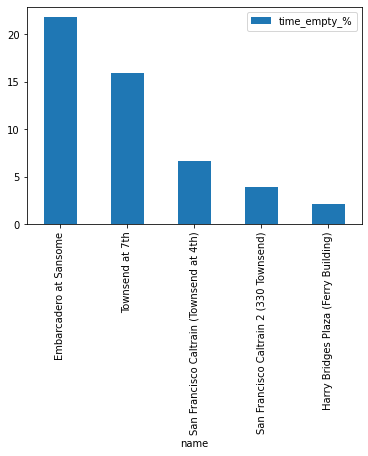

In [77]:
low_bikes.plot.bar(x='name', y='time_empty_%')

From the table above, we can see that for the top 5 stations that people start their commutes at, there is a significant percentage of the time (i.e. ~22%, ~16% with very few bikes available, during the high demand commute times. This is an issue for commuters who rely on the bikes for travel and a loss of a potential customer for Lyft.
I would recommend 2 offers to help mitigate this problem:
- 1) Offer reduced rates on rides where users dock their bikes at stations with low bike availability. This incentivizes users to help reduce the shortage of bikes at popular stations.
- 2) Offer a priority package for users with the option to reserve bikes ahead of time. After paying a premium, users would be able to reserve a bike that they know they will need to complete their commute.

## Seasonal Passes
I organized the bike share data into seasonal use, based on which month the trip was conducted in. 

```sql
SELECT month_str, count(trip_id) AS num_trips
FROM `liquid-receiver-288223.bike_trip_data.dow_time_trips`
GROUP BY month_str
ORDER BY num_trips DESC
```

In [45]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT month_str AS season, count(trip_id) AS num_trips FROM `liquid-receiver-288223.bike_trip_data.dow_time_trips` GROUP BY month_str ORDER BY num_trips DESC' > seasonal_trips.csv

Waiting on bqjob_r1628fb73720d83d_00000174dd78ffbf_1 ... (2s) Current status: DONE   


In [46]:
seasonal_trips = pd.read_csv('seasonal_trips.csv')

In [47]:
seasonal_trips

,season,num_trips
0,Summer,276787
1,Fall,254790
2,Spring,252337
3,Winter,199734


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Text(0, 0.5, 'number of trips')

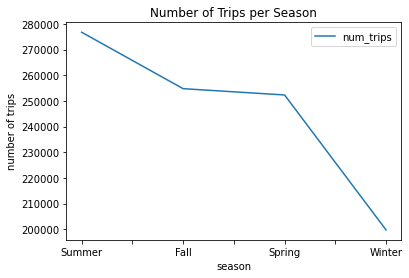

In [147]:
seasonal_trips.plot(x='season', y='num_trips')
plt.title('Number of Trips per Season')
plt.ylabel('number of trips')

We can see from the plot above that the most popular time to use bike sharing is in the summer. As the year progresses, the number of bike share trips declines in the fall and spring, and then drastically drops in the winter. I would recommend offering a seasonal pass option where user are able to get discounted rates for a season of their choosing. This would promote increased usage in the months where either the weather conditions are preferrable or their schedule is more permissive for bike rides.

## Passes for Special Days/Events
First I organized the bike trip data by volume of trips per day. Trips were limited to a duration of 1 day.

```sql
SELECT DATE(start_date) AS day, count(*) AS num_trips
FROM `liquid-receiver-288223.bike_trip_data.bikeshare_trips` 
WHERE duration_sec < 86400
GROUP BY day
ORDER BY num_trips DESC
```

In [78]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT DATE(start_date) AS day, count(*) AS num_trips FROM `liquid-receiver-288223.bike_trip_data.bikeshare_trips` WHERE duration_sec < 86400 GROUP BY day ORDER BY num_trips DESC' > trips_by_day.csv

Waiting on bqjob_r6b0360855c491cd0_00000174ddcd5b7d_1 ... (2s) Current status: DONE   


In [79]:
trips_by_day = pd.read_csv('trips_by_day.csv')

In [81]:
trips_by_day.head(10)

,day,num_trips
0,2014-09-15,1515
1,2014-08-26,1513
2,2016-05-12,1497
3,2014-10-14,1496
4,2014-10-29,1496
5,2014-08-27,1478
6,2015-08-26,1465
7,2014-10-16,1462
8,2014-10-02,1451
9,2015-07-28,1451


I saw that of the top 10 busiest days in our data, 8 of them were in 2014 between the months of August and October. I then looked more closely at just those months.
Looking at those dates, I recognized that the SF Giants won the World Series in 2014 and that the end of the season/post-season coincided with those months.

```sql
SELECT DATE(start_date) AS day, count(*) AS num_trips
FROM `liquid-receiver-288223.bike_trip_data.bikeshare_trips` 
WHERE duration_sec < 86400
  AND (DATE(start_date) >= '2014-08-01' AND DATE(start_date) < '2014-11-01')
GROUP BY day
```

In [120]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT DATE(start_date) AS day, count(*) AS num_trips FROM `liquid-receiver-288223.bike_trip_data.bikeshare_trips` WHERE duration_sec < 86400 AND (DATE(start_date) >= "2014-08-01" AND DATE(start_date) < "2014-11-01") GROUP BY day ORDER BY day' > aug_oct_2014.csv

Waiting on bqjob_r76d88d53f7816aa6_00000174ddff7ad3_1 ... (1s) Current status: DONE   


In [150]:
aug_oct_2014 = pd.read_csv('aug_oct_2014.csv')

In [132]:
giants_home_games=['2014-08-12','2014-08-13','2014-08-15','2014-08-16',
                  '2014-08-17','2014-08-25','2014-08-26','2014-08-27',
                   '2014-08-28','2014-08-29','2014-08-30','2014-08-31',
                  '2014-09-09', '2014-09-10','2014-09-11','2014-09-12',
                  '2014-09-13','2014-09-14','2014-09-25','2014-09-26',
                   '2014-09-27','2014-09-28','2014-10-06','2014-10-07',
                  '2014-10-14','2014-10-15','2014-10-16','2014-10-24',
                  '2014-10-25','2014-10-26']

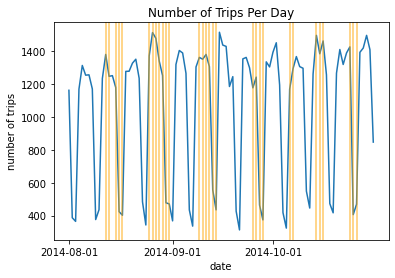

In [148]:
plt.plot(aug_oct_2014['day'], aug_oct_2014['num_trips'])
[plt.axvline(x=i, color='orange', alpha=0.6) for i in giants_home_games]
plt.title("Number of Trips Per Day")
plt.xticks(['2014-08-01', '2014-09-01', '2014-10-01'])
plt.xlabel('date')
plt.ylabel('number of trips')
plt.show()

The graph above shows the number of trips per day in 2014 from August to October. The orange lines overlaid on the trip data represents the days where there were home games for the SF Giants during their winning season. These were also some of the days with the most bike sharing activity from 2014 to 2016. It would be beneficial for Lyft to offer promotions where they partner with venues for special events so that they can incentivize people to use bike sharing as their transportation to and from the venues. This could also be extended to other special events, such as concerts, festivals, and conferences.

## Referenced views and tables

dow_time_trips: bike trip data with date and time features extracted
```sql
SELECT trip_id, duration_sec, start_station_name, end_station_name, start_station_id, end_station_id, subscriber_type, start_date,
       EXTRACT(DAYOFWEEK FROM start_date) AS dow_int,
       CASE EXTRACT(DAYOFWEEK FROM start_date)
           WHEN 1 THEN "Sunday"
           WHEN 2 THEN "Monday"
           WHEN 3 THEN "Tuesday"
           WHEN 4 THEN "Wednesday"
           WHEN 5 THEN "Thursday"
           WHEN 6 THEN "Friday"
           WHEN 7 THEN "Saturday"
           END AS dow_str,
       CASE 
           WHEN EXTRACT(DAYOFWEEK FROM start_date) IN (1, 7) THEN "Weekend"
           ELSE "Weekday"
           END AS dow_weekday,
       EXTRACT(HOUR FROM start_date) AS start_hour,
       CASE 
           WHEN EXTRACT(HOUR FROM start_date) <= 5  OR EXTRACT(HOUR FROM start_date) >= 23 THEN "Nightime"
           WHEN EXTRACT(HOUR FROM start_date) >= 6 and EXTRACT(HOUR FROM start_date) <= 8 THEN "Morning"
           WHEN EXTRACT(HOUR FROM start_date) >= 9 and EXTRACT(HOUR FROM start_date) <= 10 THEN "Mid Morning"
           WHEN EXTRACT(HOUR FROM start_date) >= 11 and EXTRACT(HOUR FROM start_date) <= 13 THEN "Mid Day"
           WHEN EXTRACT(HOUR FROM start_date) >= 14 and EXTRACT(HOUR FROM start_date) <= 16 THEN "Early Afternoon"
           WHEN EXTRACT(HOUR FROM start_date) >= 17 and EXTRACT(HOUR FROM start_date) <= 19 THEN "Afternoon"
           WHEN EXTRACT(HOUR FROM start_date) >= 20 and EXTRACT(HOUR FROM start_date) <= 22 THEN "Evening"
           END AS start_hour_str,
       EXTRACT(MONTH FROM start_date) AS month_int,
       CASE 
           WHEN EXTRACT(MONTH FROM start_date) = 12 OR EXTRACT(MONTH FROM start_date) <= 2 THEN "Winter"
           WHEN EXTRACT(MONTH FROM start_date) >= 3 and EXTRACT(MONTH FROM start_date) <= 5 THEN "Spring"
           WHEN EXTRACT(MONTH FROM start_date) >= 6 and EXTRACT(MONTH FROM start_date) <= 8 THEN "Summer"
           WHEN EXTRACT(MONTH FROM start_date) >= 9 and EXTRACT(MONTH FROM start_date) <= 11 THEN "Fall"
           END AS month_str
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
ORDER BY start_date ASC
```

low_bikes: the stations and amount of time instances when there were fewer than 3 bikes
```sql
SELECT station_id, count(time) AS low_bikes FROM `liquid-receiver-288223.bike_trip_data.time_station_status` 
WHERE dow_weekday='Weekday'
  AND (hour_str="Morning" OR hour_str="Afternoon")
  AND bikes_available < 3
GROUP BY station_id
ORDER BY low_bikes DESC
```

most_popular_commuter_trips: start and end stations for commuter trips in descending popularity order
```sql
SELECT start_station_name, end_station_name, count(*) AS num_trips FROM `liquid-receiver-288223.bike_trip_data.commuter_trips` 
GROUP BY start_station_name, end_station_name 
ORDER BY num_trips DESC
```